### 47.7 PROJECT. ###



ЗАДАНИЕ:

1. Оценить количество ботов, которые заходят на наш сайт, и их долю от всего трафика.
2. Определить, с каких источников и в какое время суток чаще всего заходят роботы.


* с 1 по 30 сентября 2020 года

Напишем запрос и подготовим полученные данные для анализа

In [ ]:
import pandas as pd
import json
import requests
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns


params = {'metrics': 'ym:s:visits,ym:s:robotPercentage', #метрики: визиты, %роботности
          'dimensions': 'ym:s:lastsignTrafficSource,ym:s:isRobot,ym:s:hour',  #группировки: источники трафика, робот/пользователь, час
          'date1': '2020-09-01',
          'date2': '2020-09-30',
          'ids': 30177909,
          'accuracy':'full',
          'limit':100000}

token = 'y0_AgAAAAA6irGLAAkvSAAAAADdDRJltzuvkW56TAyRTDvoewz39iaxcCM'
headers = {'Authorization': 'OAuth ' + token}
response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)

print (f'Разрешен ли доступ :{response.status_code} (если 200 разрешен)')
metrika_data = response.json()
print("Тип данных: ", type(metrika_data))
print("Кол-во строк:", metrika_data['total_rows'])


#функция, которая избавляет от сложной структуры вложенностей, приводим к списку словарей
def getMetrikaDataInListOfDicts(metrika_data):
    list_of_dicts = []
    dimensions_list = metrika_data['query']['dimensions']
    metrics_list = metrika_data['query']['metrics']
    for data_item in metrika_data['data']:
        d = {}
        for i,dimension in enumerate(data_item['dimensions']):
            d[dimensions_list[i]] = dimension['name']
        for i,metric in enumerate(data_item['metrics']):
            d[metrics_list[i]] = metric
        list_of_dicts.append(d)
    return list_of_dicts


metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrika_data)
metrika_df = pd.DataFrame(metrika_list_of_dicts)#приводим полученную структуру к табличному виду DataFrame
metrika_df.columns = ['Source','Robot_User','Hour','Visits','botPercentage'] #изменяем названия столбцов
display(metrika_df)#готовый DataFrame

Разрешен ли доступ :200 (если 200 разрешен)
Тип данных:  <class 'dict'>
Кол-во строк: 182


,Source,Robot_User,Hour,Visits,botPercentage
0,Search engine traffic,People,16:00,189.0,0.0
1,Search engine traffic,People,15:00,177.0,0.0
2,Search engine traffic,People,11:00,169.0,0.0
3,Search engine traffic,People,12:00,169.0,0.0
4,Search engine traffic,People,14:00,167.0,0.0
...,...,...,...,...,...
177,Social network traffic,Robots,15:00,1.0,100.0
178,Social network traffic,Robots,16:00,1.0,100.0
179,Social network traffic,Robots,21:00,1.0,100.0
180,Recommendation system traffic,People,08:00,1.0,0.0



1. Оценить количество ботов, которые заходят на наш сайт, и их долю от всего трафика.

In [ ]:
#Создаем сводную таблицу по виду пользователя(робот или user)
metrika_df_pv = metrika_df.pivot_table(values='Visits', index='Robot_User', aggfunc='sum')
metrika_df_pv['%_users'] = round((metrika_df_pv['Visits']/metrika_df_pv['Visits'].sum())*100,2)

display(metrika_df_pv)

,Visits,%_users
Robot_User,,
People,3353.0,77.71
Robots,962.0,22.29


Text(0.5, 1.0, 'Доля роботов в общем количестве визитов')

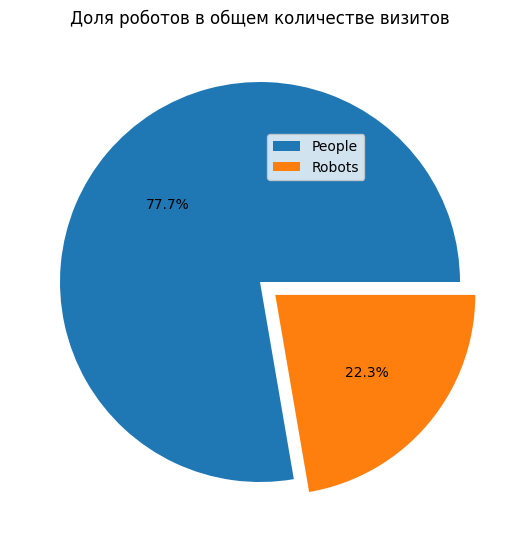

In [ ]:
#Создаем круговую диаграмму
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])

axes.pie(
    metrika_df_pv['Visits'],
    autopct='%.1f%%',
    explode = [0, 0.1],
    labeldistance = 0.1
)
axes.legend(metrika_df_pv.index,
          loc="center left",
          bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
axes.set_title('Доля роботов в общем количестве визитов')

ВЫВОД 1.:
Если параметр выше 10% — его надо снижать.(https://habr.com/ru/post/657451/) В нашем случае, процент роботности 22,3%, т.е показатель выше допустимого и необходимы доработки закрывающие доступ некоторым роботам к определённым разделам сайта. Также нужно учитывать, что есть и хорошие роботы, например  пауки поисковых систем, которые индексируют контент блога, их работу блокировать не нужно.

2. Определить, с каких источников и в какое время суток чаще всего заходят роботы.

In [ ]:
#Создаем сводную таблицу, по источникам трафика + фильтруем, выделяем только роботные визиты
metrika_df_pv_sourse = metrika_df[metrika_df['Robot_User']=='Robots'].pivot_table(values='Visits', index='Source', aggfunc='sum')
display(metrika_df_pv_sourse.sort_values('Visits', ascending=False))

,Visits
Source,
Search engine traffic,739.0
Direct traffic,177.0
Link traffic,31.0
Social network traffic,11.0
Internal traffic,3.0
Cached page traffic,1.0


Text(0.5, 1.0, 'Источники роботных визитов')

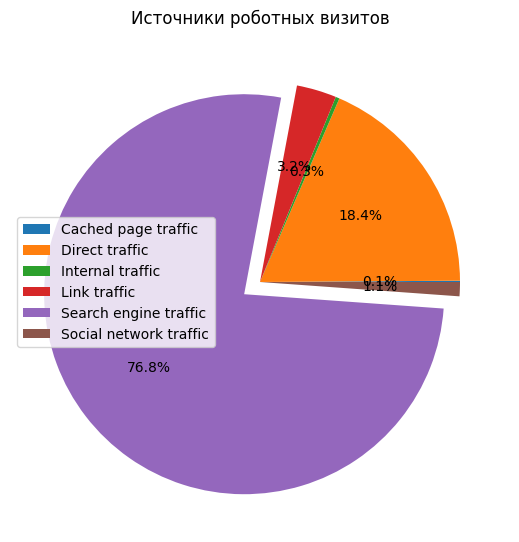

In [ ]:
#Создаем круговую диаграмму
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])

axes.pie(
    metrika_df_pv_sourse['Visits'],
    autopct='%.1f%%',
    explode = [0, 0,0,0,0.1,0],
    labeldistance = 0.7
)
axes.legend(metrika_df_pv_sourse.index,
          loc="center left",
          bbox_to_anchor=(0, 0, 0, 1))
axes.set_title('Источники роботных визитов')

In [ ]:
#Создаем сводную таблицу, по источникам трафика и времени дня + фильтруем, выделяем только роботные визиты
metrika_df_pv_hour = metrika_df[metrika_df['Robot_User']=='Robots'].pivot_table(values='Visits', index='Source',columns='Hour',fill_value=0, aggfunc='sum')
metrika_df_pv_hour.columns.astype('string')#для корректной работы тепловой карты
display(metrika_df_pv_hour)


Hour,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Source,,,,,,,,,,,,,,,,,,,,,
Cached page traffic,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Direct traffic,2,4,2,2,3,3,3,5,5,12,...,14,6,8,9,9,10,8,13,6,8
Internal traffic,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
Link traffic,0,0,0,1,0,0,2,1,1,1,...,2,1,3,2,1,0,2,0,1,1
Search engine traffic,17,8,5,3,3,1,3,6,29,36,...,58,63,62,55,31,38,26,29,30,21
Social network traffic,0,0,0,0,0,0,0,0,1,1,...,0,1,1,0,0,0,0,1,3,0


Text(0.5, 1.0, 'Тепловая карта распределения количества роботных визитов по источникам трафика и времени')

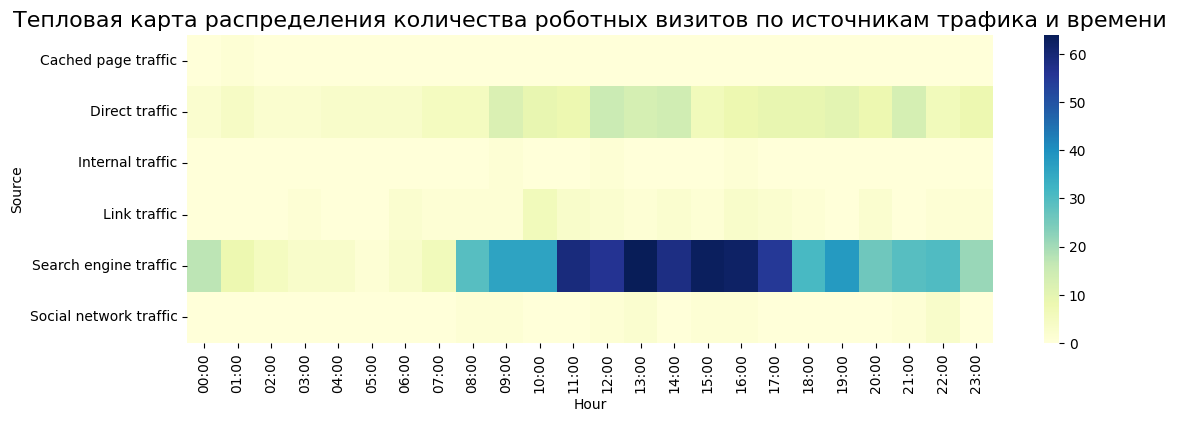

In [ ]:
#строим тепловую карту по сводной таблице
fig2 = plt.figure(figsize=(13, 4))
heatmap = sns.heatmap(data=metrika_df_pv_hour, cmap='YlGnBu')
heatmap.set_title('Тепловая карта распределения количества роботных визитов по источникам трафика и времени', fontsize=16)

ВЫВОД 2.:

Основной источник роботных сеансов - Search engine traffic 76,8% (переходы из поисковых систем) от всех роботных визитов(скорее всего это роботы поисковых систем, которые индексируют сайт), далее Direct traffic 18,4% (прямые переходы) и Link traffic 3,2%.

Распределение по часам подтверждает, что больше всего роботных визитов из источника Search engine traffic. В период времени с 11:00-17:00 шкала Search engine traffic имеет ярко-синие ячейки, что соответствует наибольшему количеству визитов. Начало активности можно выделить с 8:00 , затем рост активности в рабочие часы и снижение активности после 17:00, ночью 1:00 - 7:00 активность минимальная. Для Direct traffic всплески активности наблюдаются в 9:00 и 12:00-15:00 и в вечерние 21:00. Link traffic можно отметить небольшой всплеск в 10:00